# Étude des nouveaux itinéraires calculés avec OSRM

On commence ici une étude comparative des itinéraires OSRM fournis par le jeu de données des itinéraires calculés sur nos deux nouveaux profils.

On notera que les s'intéresse à l'écart qu'il existe entre ces deux prédictions. On notera qu'il existe

In [1]:
import pandas as pd
import scipy as sp
import os
import numpy as np
import pprint
import seaborn as sns
import seaborn as sns
import json

from colour import Color
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML

In [2]:
import sys

sys.path.insert(0, os.path.join(os.path.dirname(os.path.realpath(".")), "code"))

# Home-made helpers functions
from interfaces import *
from settings import TRAINING_DATA, SUBMISSION_FOLDER, TO_PREDICT, delta_transit, INDEX_COLUMN, TESTING_DATA, TRANSFORMED_DATA, X_TRAIN, X_TEST, DATA_FOLDER
from utils import load_x, load_ytrain

from preprocessing import add_newer_osmr_response, add_vehicle_info

Using TensorFlow backend.


In [3]:
# make /comfy/ notebook 
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.rcParams["figure.figsize"] = (30, 10)
sns.set(color_codes=True)

In [4]:
x_train = load_x(TRAINING_DATA / "x_train.csv")
y_train = load_ytrain()

In [5]:
x_clean = add_newer_osmr_response(add_vehicle_info(x_train))

INFO:root: → STEP: Add vehicle information
INFO:root: → STEP: OSMR and transit features


In [6]:
cols = ["OSRM estimated distance", "distance", "OSRM estimated duration", "duration", "heavy vehicle", "very heavy vehicle"]
x = x_clean[cols]

In [7]:
plt.figure()
plt.subplot(1, 2, 1)
plt.scatter(x["OSRM estimated distance"], x["distance"])
plt.ylabel("New estimated distance")
plt.xlabel("Old estimated distance")

plt.subplot(1, 2, 2)
plt.scatter(x["OSRM estimated duration"], x["duration"])
plt.ylabel("New estimated duration")
plt.xlabel("Old estimated duration")

Text(0.5, 0, 'Old estimated duration')

On trouve les points associés aux différences extrèmes pour la durée estimée.

In [8]:
diff = np.abs(x_clean["duration"] - x_clean["OSRM estimated duration"])
diff_abs = np.abs(diff).sort_values()

In [9]:
outliers_index = diff_abs[-1000:].index

In [10]:
outliers_index

Int64Index([4797876, 4757348, 5371463, 4773350, 5454439, 4756840, 4802183,
            5451089, 5451090, 4808750,
            ...
            4803507, 4831338, 5435008, 4943856, 5085088, 4742664, 4835346,
            4850286, 4788120, 4850287],
           dtype='int64', name='emergency vehicle selection', length=1000)

In [11]:
cols = ["OSRM estimated distance", "distance", "OSRM estimated duration", "duration", "heavy vehicle", "very heavy vehicle"] + list(y_train.columns)
large_values = x_clean[x_clean.index.isin(outliers_index)].join(y_train)[cols]
large_values_heavy = large_values[large_values["heavy vehicle"] + large_values["very heavy vehicle"] == 1]
large_values_light = large_values[large_values["heavy vehicle"] + large_values["very heavy vehicle"] == 0]

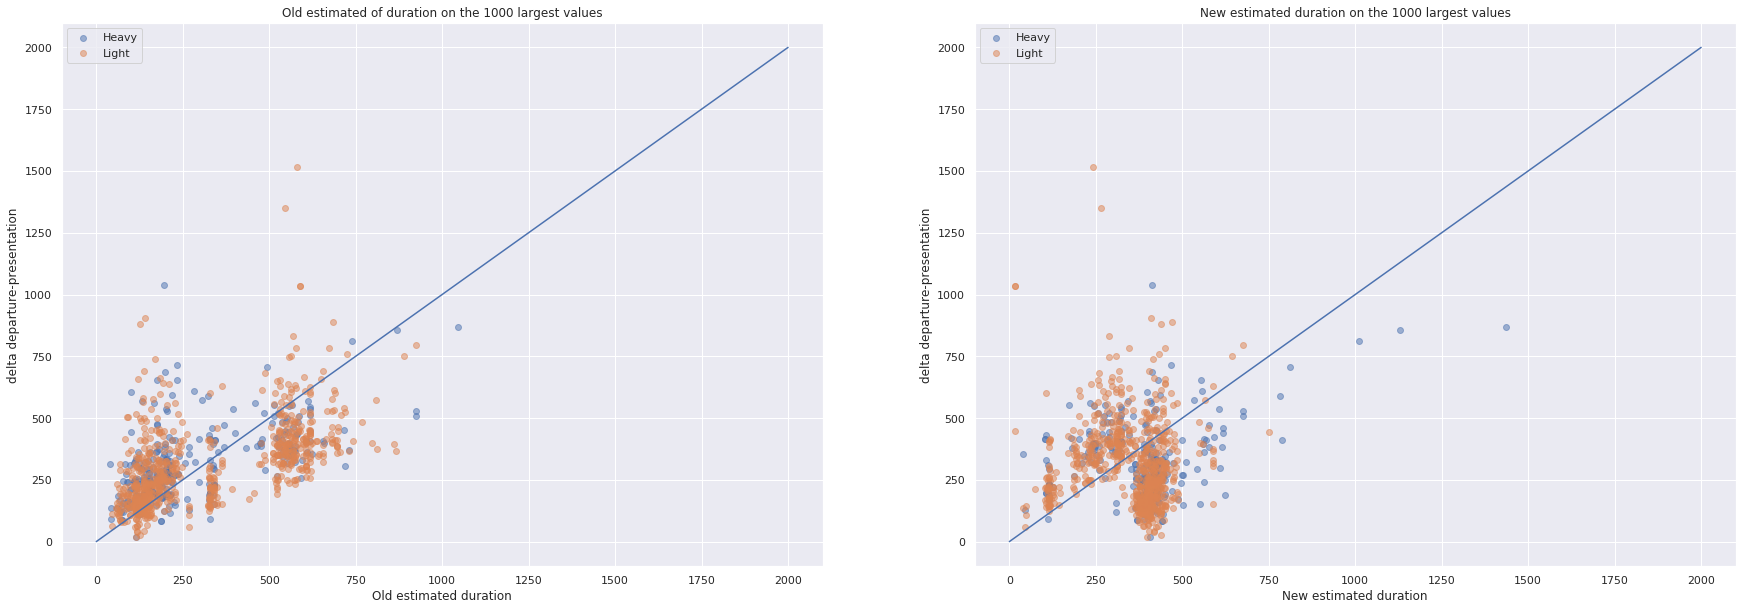

In [12]:
plt.subplot(1,2,1)
plt.scatter(large_values_heavy["OSRM estimated duration"], large_values_heavy["delta departure-presentation"], alpha=0.5)
plt.scatter(large_values_light["OSRM estimated duration"], large_values_light["delta departure-presentation"], alpha=0.5)
plt.legend(["Heavy", "Light"])
plt.xlabel("Old estimated duration")
plt.ylabel("delta departure-presentation")
plt.title("Old estimated of duration on the 1000 largest values")
plt.plot([0, 2000],[0, 2000])

plt.subplot(1,2,2)
plt.scatter(large_values_heavy["duration"], large_values_heavy["delta departure-presentation"], alpha=0.5)
plt.scatter(large_values_light["duration"], large_values_light["delta departure-presentation"], alpha=0.5)
plt.legend(["Heavy", "Light"])
plt.xlabel("New estimated duration")
plt.ylabel("delta departure-presentation")
plt.title("New estimated duration on the 1000 largest values")
plt.plot([0, 2000],[0, 2000])

In [13]:
t = x[x["heavy vehicle"] + x["very heavy vehicle"] == 1]
print("Interventions avec véhicule lourds", len(t))

diff = t["duration"] - t["OSRM estimated duration"]
diff2 = t["distance"] - t["OSRM estimated distance"]
plt.hist(diff, bins=int(np.sqrt(len(diff))), density=True, range=(-200, 200)) ;
plt.hist(diff2, bins=int(np.sqrt(len(diff))), density=True, range=(-200, 200)) ;
plt.legend(["Différence entre durée d'itinéraire", "Différence entre distance d'itinéraire"])
plt.title("Véhicules lourds et très lourds")

Interventions avec véhicule lourds 47249


Text(0.5, 1.0, 'Véhicules lourds et très lourds')

In [14]:
diff.max()

459.6

172088


Text(0.5, 1.0, 'Véhicules légers et autres')

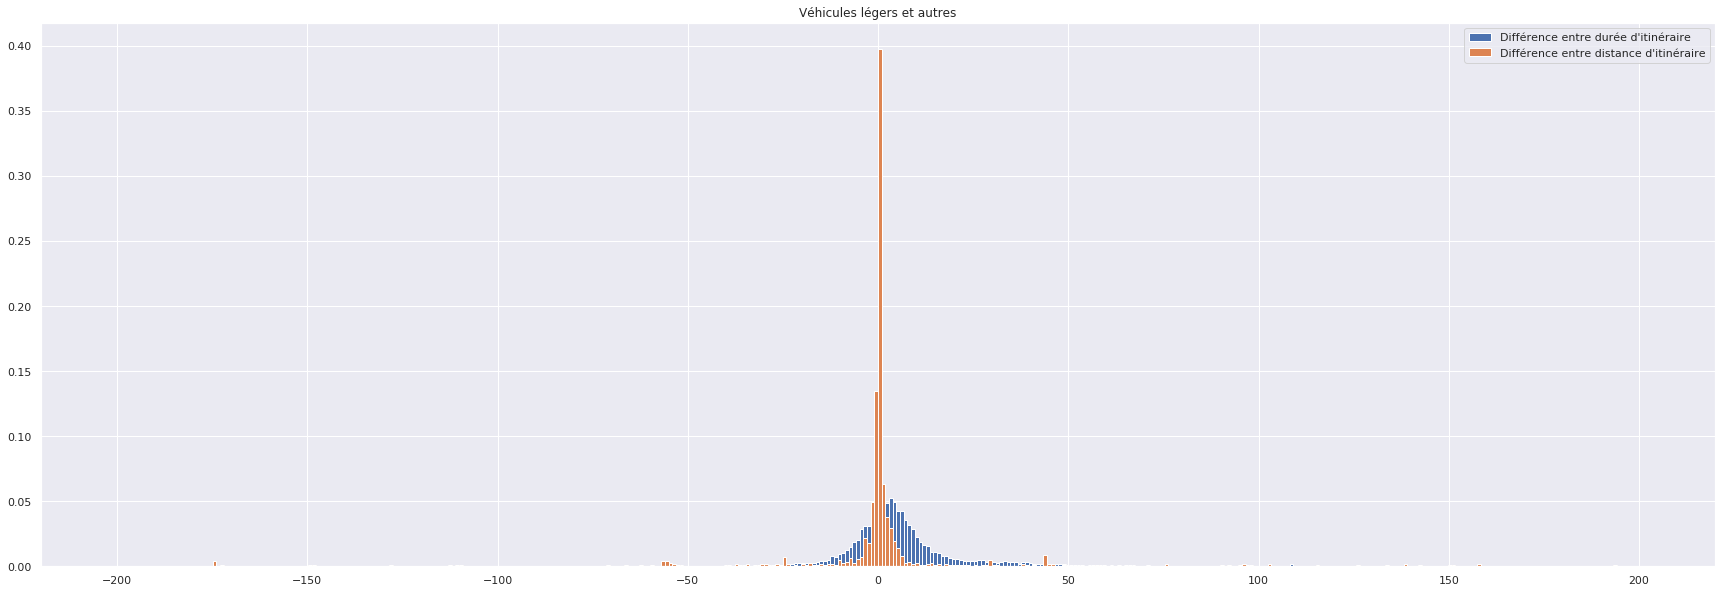

In [15]:
t = x[x["heavy vehicle"] + x["very heavy vehicle"] == 0]
print(len(t))

diff = t["duration"] - t["OSRM estimated duration"]
diff2 = t["distance"] - t["OSRM estimated distance"]
plt.hist(diff, bins=int(np.sqrt(len(diff))), density=True, range=(-200, 200)) ;
plt.hist(diff2, bins=int(np.sqrt(len(diff))), density=True, range=(-200, 200)) ;
plt.legend(["Différence entre durée d'itinéraire", "Différence entre distance d'itinéraire"])
plt.title("Véhicules légers et autres")